# TO-DOs

+ Init lda to NMF. Sufficient to manage to install this modified version of lda package, needed for init lda to NMF:
```!pip install --upgrade git+git://github.com/llaurabat91/lda.git``` (currently not working) (C)
+ Add pLSA (C)
+ averaging word embeddings from Word2Vec SkipGram (C)
+ averaging word embeddings from GloVe (C)
+ tfidf-weighted word embeddings from Word2Vec SkipGram (L)
+ tfidf-weighted word embeddings from GloVe (L)
+ Check d2v is solid (very low similarities, maybe bug?) (L)
+ Prettify all plots (L)
+ Add hyperparams set-up to an overleaf (C)

In [34]:
# Install necessary packages
# !pip install gdown
# !pip install --upgrade gensim

In [30]:
#!pip install lda

In [35]:
# Restart RUNTIME after installing packages!

In [31]:
import pandas as pd
import numpy as np
import gdown
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from itertools import product, combinations_with_replacement
import lda
import pickle

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy import linalg
from sklearn.decomposition import NMF
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import itertools

import sys
sys.path.append('../pymodules')

In [3]:
# run this if interested in the Additional section
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 118)
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.width', 10000)

In [4]:
# define paths and seed
seed = 92
data_path = "./"

In [5]:
# define dictionary with paths to data in Google Drive
data_url_dict = {"10K_vocab_2019_min25": ("https://drive.google.com/uc?id=1zbn6Tlz6ZJvH1MtxXDr09XD36IKBhqJ1", "csv"),
                "10K_dtmatrix_2019_min25": ("https://drive.google.com/uc?id=1j4FREal_tU8f6l_3GnI4rLsOIFrS6fw4", "csv"),
                "10K_raw_text_2019_min25": ("https://drive.google.com/uc?id=13-kfuMQu9GveYFZ0lAeVsPOSiZVdB5Ev", "csv"),
                "w2v_sg_min25": ("https://drive.google.com/uc?id=161MMqGjtDwOkU_ERzWNV82m14p4QJzmL", "sav"),
                "glove_min25": ("https://drive.google.com/uc?id=1EHeoKSd3Z8Z3J1Pg8-n5d98GwiY3wPQx", "sav"),
                "tic_cik_crosswalk": ("https://drive.google.com/uc?id=1YsbeWapKf_hvfP3qMo9-Xj-PFuH5R96o", "csv")}

In [6]:
# download each file in the dictionary (it takes a while)
for file_name, attributes in data_url_dict.items():
    url = attributes[0]
    extension = attributes[1]
    gdown.download(url, f"{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1zbn6Tlz6ZJvH1MtxXDr09XD36IKBhqJ1
To: /home/cmarangon/Dropbox/RA_work/ARE_text/text_algorithms_econ/notebooks/10K_vocab_2019_min25.csv
100%|██████████| 407k/407k [00:00<00:00, 424kB/s]
Downloading...
From: https://drive.google.com/uc?id=1j4FREal_tU8f6l_3GnI4rLsOIFrS6fw4
To: /home/cmarangon/Dropbox/RA_work/ARE_text/text_algorithms_econ/notebooks/10K_dtmatrix_2019_min25.csv
100%|██████████| 300M/300M [03:10<00:00, 1.57MB/s] 
Downloading...
From: https://drive.google.com/uc?id=13-kfuMQu9GveYFZ0lAeVsPOSiZVdB5Ev
To: /home/cmarangon/Dropbox/RA_work/ARE_text/text_algorithms_econ/notebooks/10K_raw_text_2019_min25.csv
100%|██████████| 1.33G/1.33G [10:50<00:00, 2.05MB/s]
Downloading...
From: https://drive.google.com/uc?id=161MMqGjtDwOkU_ERzWNV82m14p4QJzmL
To: /home/cmarangon/Dropbox/RA_work/ARE_text/text_algorithms_econ/notebooks/w2v_sg_min25.sav
100%|██████████| 104M/104M [00:51<00:00, 2.01MB/s] 
Downloading...
From: https://drive.google.com/u

# 1. Load data

This tutorial uses text data from the **10-K reports** filed by most publicly-traded firms in the U.S. in 2019. 10-K reports are a very rich source of data since firms include information regarding their organizational structure, financial performance and risk factors. We will use a version of the data where the risk factors section of each report has been splitted into sentences and each sentence has been assigned an ID that combines the firm identifier (i.e. **CIK**) and a sentence number. The data we use has a total of 1,077,416 sentences for 2,500 firms.

More on the 10-K reports [here](https://www.investor.gov/introduction-investing/getting-started/researching-investments/how-read-10-k).

In [7]:
raw_data = pd.read_csv(data_path + '10K_raw_text_2019_min25.csv', index_col='Unnamed: 0')

In [8]:
dt_mat = pd.read_csv(data_path + '10K_dtmatrix_2019_min25.csv', index_col='Unnamed: 0')
dt_vals = dt_mat.values

In [9]:
dt_mat.shape

(4033, 18588)

In [10]:
vocab_df = pd.read_csv(data_path + '10K_vocab_2019_min25.csv', index_col='Unnamed: 0')

In [11]:
vocab = vocab_df.to_dict()['0']

In [12]:
tics = pd.read_csv(data_path+'tic_cik_crosswalk.csv') #3196
raw_data.cik.isin(tics.cik).sum()

3196

In [13]:
# alternative ticker datasets (even fewer matches)

# tickers = pd.read_csv('../../cik_ticker.csv', sep='|') #2684
# tickers2 = pd.read_csv('../../ticker_2.txt', sep='\t', header=None, names=['ticker', 'cik']) #3183

In [14]:
df = raw_data.merge(tics, on='cik', how='left').copy()

# Documents as frequency vectors: an illustration

In [23]:
names_cosine =  ['AAPL', 'GOOGL', 'KO', 'PEP', 'DAL', 'LUV', 'CALM', 'BALL', 'BUKS']
idxs_cosine = np.array(df[df.tic.isin(names_cosine)].index)
cosine_dict = {k:v for k,v in zip(names_cosine, idxs_cosine)}

In [24]:
cosine_similarities = {f'{k1}_{k2}':cosine_similarity(dt_vals[cosine_dict[k1]].reshape(1, -1), 
                                                      dt_vals[cosine_dict[k2]].reshape(1, -1))[0][0] 
                       for k1, k2 in list(combinations_with_replacement(names_cosine, 2))
                      if k1!=k2}
cosine_similarities = {k: v for k, v in sorted(cosine_similarities.items(), key=lambda item: item[1])}

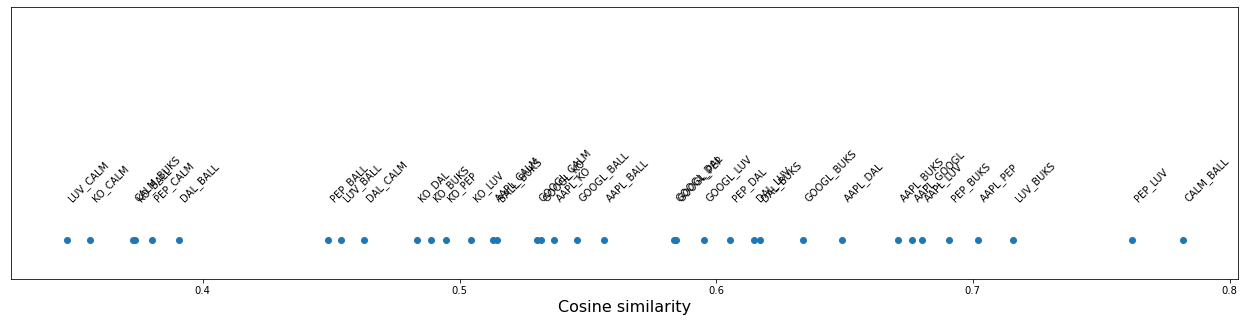

In [25]:
fig, ax = plt.subplots(figsize=(22,5))

k = len(cosine_similarities)
sims = list(cosine_similarities.values())
names = list(cosine_similarities.keys())

ax.scatter(sims, np.zeros((k,)) )
for i in range(k):
    ax.annotate(names[i], (sims[i], 0+0.005), rotation=45)
ax.set_ylim(bottom=-0.005, top=0.03)
ax.set_xlabel('Cosine similarity', fontsize=16)
ax.set_yticks([])    
plt.show()

In [26]:
companies =  ['AAPL', 'GOOGL', 'KO', 'PEP', 'DAL', 'LUV']
temp = df[df.tic.isin(companies)]
idxs_comps = np.array(temp.index).astype(int)
names_comps = temp.tic.values

In [27]:
target_dict = {'customer':4394, 'airline':1172, 'environment':5876, 'price':12951, 'product':13154,
               'outsourcing':11949}
terms = list(target_dict.keys())
ixs_terms = np.array(list(target_dict.values())).astype(int)

In [28]:
heatmap_df = pd.DataFrame(dt_vals[idxs_comps][:,ixs_terms], columns=terms, index=names_comps)
heatmap_df

,customer,airline,environment,price,product,outsourcing
KO,10.0,0.0,6.0,12.0,65.0,0.0
DAL,3.0,15.0,3.0,8.0,5.0,0.0
PEP,22.0,0.0,7.0,12.0,148.0,0.0
LUV,3.0,14.0,1.0,4.0,1.0,1.0
AAPL,15.0,0.0,1.0,2.0,75.0,9.0
GOOGL,20.0,0.0,1.0,2.0,83.0,0.0


In [29]:
heatmap_df_rel = heatmap_df/heatmap_df.sum(0)

In [30]:
heatmap_df_rel

,customer,airline,environment,price,product,outsourcing
KO,0.136986,0.000000,0.315789,0.30,0.172414,0.0
DAL,0.041096,0.517241,0.157895,0.20,0.013263,0.0
PEP,0.301370,0.000000,0.368421,0.30,0.392573,0.0
LUV,0.041096,0.482759,0.052632,0.10,0.002653,0.1
AAPL,0.205479,0.000000,0.052632,0.05,0.198939,0.9
GOOGL,0.273973,0.000000,0.052632,0.05,0.220159,0.0


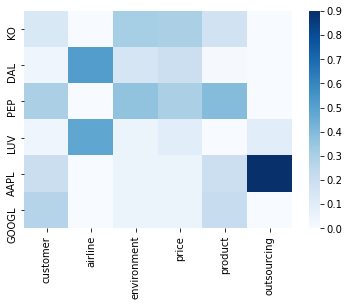

In [31]:
sns.heatmap(heatmap_df_rel, cmap='Blues')#, annot=heatmap_df)
plt.show()

In [71]:
# alternative visualization (not very insightful)
# fig, ax = plt.subplots()

# ax.scatter(x=heatmap_df['price'], y=heatmap_df['product'])
# ax.set_xlabel('price', fontsize=12)
# ax.set_ylabel('product', fontsize=12)

# names = ['AAPL', 'GOOGL', 'KO', 'PEP', 'DAL', 'LUV']
# for i in range(len(heatmap_df['price'])):
#     plt.annotate(names[i], (heatmap_df['price'][i]+0.2, heatmap_df['product'][i] + 0.6))

# plt.show()

# Estimate models

In [15]:
# %%
# Get BoW and set K
X = dt_vals
K = 20

In [16]:
# %%
# few seconds
# TFIDF
tfidf =TfidfTransformer(norm=u'l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
X_tfidf =tfidf.fit_transform(X)

X_tfidf = np.asarray(X_tfidf.todense())

In [17]:
# %%
np.save(data_path + 'X_tfidf.npy', X_tfidf)

In [18]:
%%time
# %%
# 8 min
# LSA
U, D, Vt = linalg.svd(X)
print(U.shape,  D.shape, Vt.shape)

Vt_r = Vt[:K]
print(Vt_r.shape)

X_LSA = X@Vt_r.T
print(X_LSA.shape)
# %%

(4033, 4033) (4033,) (18588, 18588)
(20, 18588)
(4033, 20)
CPU times: user 20min 2s, sys: 59.4 s, total: 21min 2s
Wall time: 2min 46s


In [19]:
np.save(data_path + 'X_LSA.npy', X_LSA)

In [20]:
%%time
# %%

#pLSA

##TODO

CPU times: user 18 µs, sys: 2 µs, total: 20 µs
Wall time: 7.87 µs


In [21]:
%%time
# %%
# 10min
# NMF

NMFmodel = NMF(n_components=K, init='random', random_state=0,
max_iter=800)
X_NMF = NMFmodel.fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


CPU times: user 40min 29s, sys: 6min 13s, total: 46min 43s
Wall time: 5min 58s


In [22]:
# %%
np.save(data_path + 'X_NMF.npy', X_NMF)

In [32]:
%%time
# 30min
# LDA
X = X.astype('int64')
lda_model = lda.LDA(n_topics=K, n_iter=1500, random_state=1)
X_lda =  lda_model.fit_transform(X) 

INFO:lda:n_documents: 4033
INFO:lda:vocab_size: 18588
INFO:lda:n_words: 21471379
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -233401720
INFO:lda:<10> log likelihood: -211247377
INFO:lda:<20> log likelihood: -192430858
INFO:lda:<30> log likelihood: -188535562
INFO:lda:<40> log likelihood: -186779294
INFO:lda:<50> log likelihood: -185815838
INFO:lda:<60> log likelihood: -185139687
INFO:lda:<70> log likelihood: -184629565
INFO:lda:<80> log likelihood: -184253768
INFO:lda:<90> log likelihood: -183920986
INFO:lda:<100> log likelihood: -183682284
INFO:lda:<110> log likelihood: -183482021
INFO:lda:<120> log likelihood: -183330302
INFO:lda:<130> log likelihood: -183166446
INFO:lda:<140> log likelihood: -183013730
INFO:lda:<150> log likelihood: -182908032
INFO:lda:<160> log likelihood: -182813950
INFO:lda:<170> log likelihood: -182723860
INFO:lda:<180> log likelihood: -182610296
INFO:lda:<190> log likelihood: -182506362
INFO:lda:<200> log likelihood: -182447056
INFO

CPU times: user 1h 23min 38s, sys: 0 ns, total: 1h 23min 38s
Wall time: 1h 23min 39s


In [33]:
#%%
np.save(data_path + 'X_lda.npy', X_lda)
#%%
# X_lda = np.load(save_path + 'X_lda.npy')
#%%

In [24]:
%%time
# doc-to-vec
# 9 min
# tag documents
tagged_data = [TaggedDocument(words=doc, 
tags=[str(i)]) for i, doc in enumerate(df.tokens_25.values)]

#%%
d2v_model = Doc2Vec(tagged_data, vector_size=K, 
window=5, min_count=1, workers=4)
#%%
d2v_model.save(data_path + "d2v.model")

CPU times: user 13min 6s, sys: 1.34 s, total: 13min 7s
Wall time: 4min 48s


In [25]:
%%time
#%%
d2v_model= Doc2Vec.load(data_path + "d2v.model")

#%%
# list of sentences
# each sentence is a list of 700-dim words
X_d2v = np.array([d2v_model.dv[i] 
                        for i in range(df.shape[0])])

CPU times: user 10.6 ms, sys: 7.94 ms, total: 18.5 ms
Wall time: 18.9 ms


In [26]:
#%%
np.save(data_path + 'X_d2v.npy', X_d2v)
# %%

In [27]:
%%time
# Averaging word-to-vec
#48 sec

#load model
from gensim.models import Word2Vec
w2v_sg = Word2Vec.load('w2v_sg_min25.sav')
    
#prepare sentences
sentences = [doc.split(' ') for doc in df['final_text_25']]

sentvecs = []
for sentence in sentences:
    vecs = [w2v_sg.wv[w] for w in sentence if w in w2v_sg.wv]
    if len(vecs)== 0:
        sentvecs.append(np.nan)
        continue
    sentvec = np.mean(vecs,axis=0)
    sentvecs.append(sentvec.reshape(1,-1))
#%%
# list of sentences
# each sentence is a list of 700-dim words

X_avgw2v = [doc[0] for doc in sentvecs]## check if same format of other output
np.save(data_path + 'X_avgw2v.npy', X_avgw2v)

CPU times: user 45.2 s, sys: 345 ms, total: 45.5 s
Wall time: 45.5 s


In [35]:
%%time
# Averaging Glove
#50 sec

#load model
with open(data_path + f'glove_min25.sav', 'rb') as fr:
    glove = pickle.load(fr)
    
#prepare sentences
sentences = [doc.split(' ') for doc in df['final_text_25']]

sentvecs = []
for sentence in sentences:
    vecs = [glove.word_vectors[glove.dictionary[w]] for w in sentence if w in glove.dictionary]
    if len(vecs)== 0:
        sentvecs.append(np.nan)
        continue
    sentvec = np.mean(vecs,axis=0)
    sentvecs.append(sentvec.reshape(1,-1))
#%%
# list of sentences
# each sentence is a list of 700-dim words

X_avglove = [doc[0] for doc in sentvecs]## check if same format of other output
np.save(data_path + 'X_avglove.npy', X_avglove)

CPU times: user 44.6 s, sys: 0 ns, total: 44.6 s
Wall time: 45 s


# Cosine similarity comparison

In [36]:
#%%
X_tfidf = np.load(data_path + 'X_tfidf.npy')
X_LSA = np.load(data_path + 'X_LSA.npy')
X_NMF = np.load(data_path + 'X_NMF.npy')
X_lda = np.load(data_path + 'X_lda.npy')
X_d2v = np.load(data_path + 'X_d2v.npy')
X_avgw2v = np.load(data_path + 'X_avgw2v.npy')
X_avglove = np.load(data_path + 'X_avglove.npy')

In [37]:
####### COSINE SIMILARITIES
# %%
sims_tfidf = cosine_similarity(X_tfidf)
sims_lsa = cosine_similarity(X_LSA)
sims_nmf = cosine_similarity(X_NMF)
sims_lda = cosine_similarity(X_lda)
sims_d2v = cosine_similarity(X_d2v)
sims_avgw2v = cosine_similarity(X_avgw2v)
sims_avglove = cosine_similarity(X_avglove)
#%%

In [38]:
flat_sims_tfidf = np.array(sims_tfidf[np.tril_indices(sims_tfidf.shape[0])])
flat_sims_lsa = np.array(sims_lsa[np.tril_indices(sims_lsa.shape[0])])
flat_sims_nmf = np.array(sims_nmf[np.tril_indices(sims_nmf.shape[0])])
flat_sims_lda = np.array(sims_lda[np.tril_indices(sims_lda.shape[0])])
flat_sims_d2v = np.array(sims_d2v[np.tril_indices(sims_d2v.shape[0])])
flat_sims_avgw2v = np.array(sims_avgw2v[np.tril_indices(sims_avgw2v.shape[0])])
flat_sims_avglove = np.array(sims_avglove[np.tril_indices(sims_avglove.shape[0])])
#%%

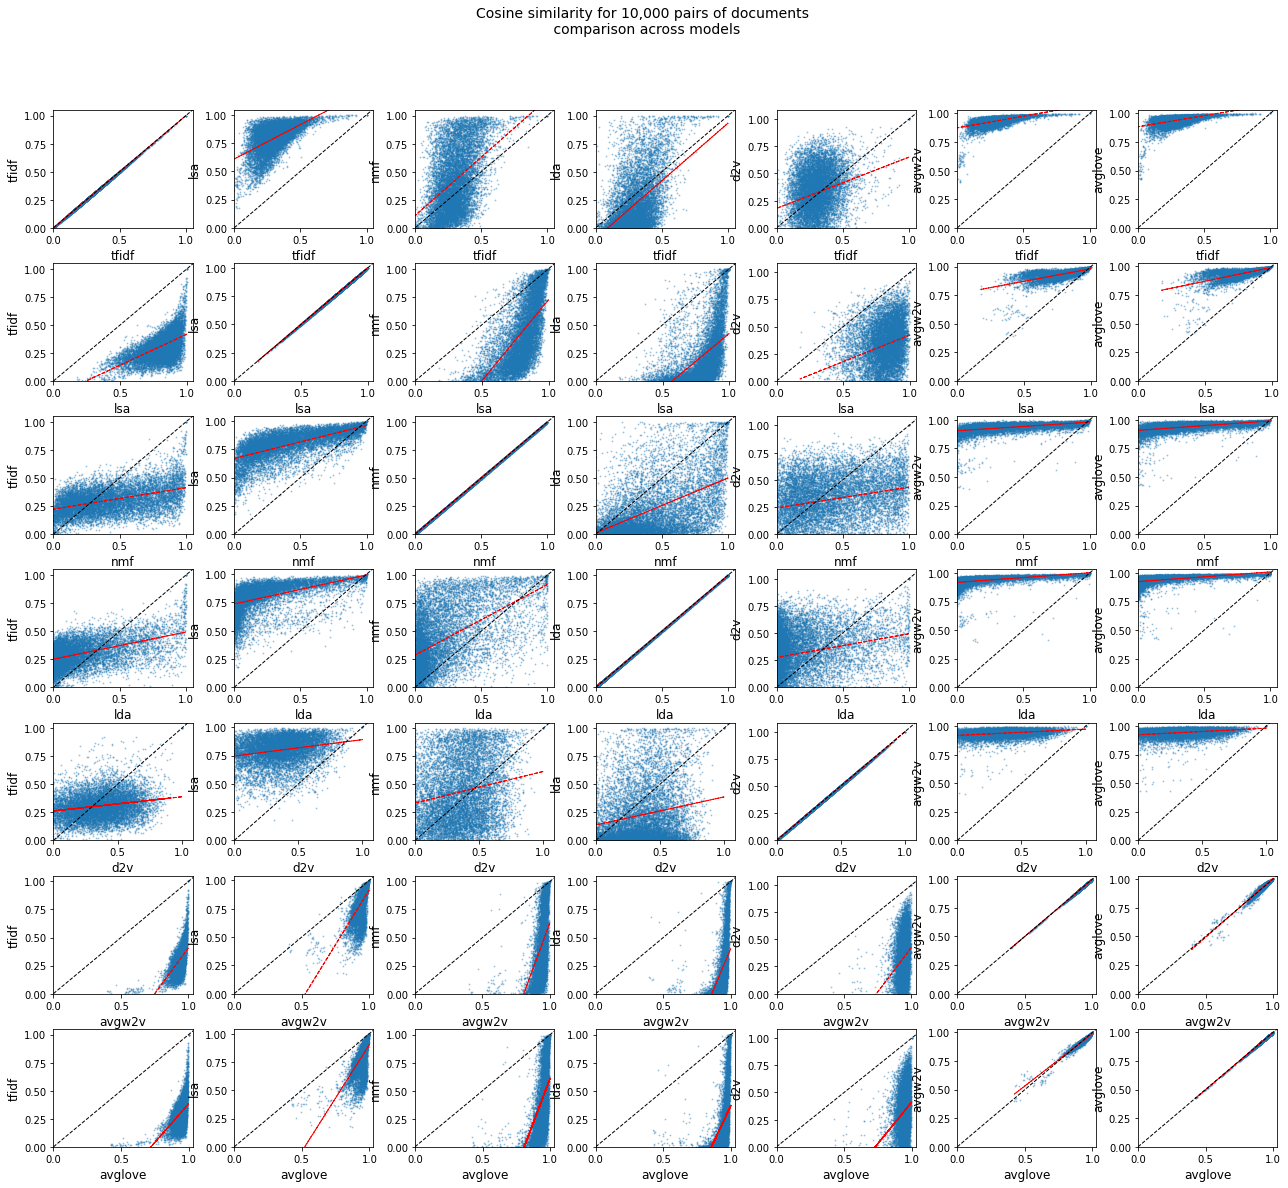

In [39]:
# l_range = 0
# u_range = 5000

# ticks = np.arange(l_range, u_range, 300)
# labs = np.array(np.tril_indices(sims_lsa.shape[0])).T
# labs = labs[ticks]

sample_range = np.linspace(0, flat_sims_tfidf.shape[0]-1,10000).astype(int)

#%%
fig, ax = plt.subplots(7,7, figsize=(18,18))
fig.suptitle('Cosine similarity for 10,000 pairs of documents \n comparison across models',
size=14)
sims_all = [flat_sims_tfidf, flat_sims_lsa, flat_sims_nmf, flat_sims_lda, 
            flat_sims_d2v, flat_sims_avgw2v, flat_sims_avglove]
names = ['tfidf', 'lsa', 'nmf', 'lda',
         'd2v', 'avgw2v', 'avglove']
scaler = StandardScaler()

for i in np.arange(7):
    for j in np.arange(7):
        x = sims_all[i][sample_range]
        y = sims_all[j][sample_range]

        # x = scaler.fit_transform(x.reshape(-1, 1) )
        # x = x.squeeze()
        # y = scaler.fit_transform(y.reshape(-1, 1) )
        # y = y.squeeze()

        ax[i][j].scatter(x,y, alpha=0.3, s=1)
        ax[i][j].set_ylim(bottom=0)
        ax[i][j].set_xlim(left=0)
        ax[i][j].set_xlabel(names[i], size=12)
        ax[i][j].set_ylabel(names[j], size=12)

        m, b = np.polyfit(x, y, 1)
        ax[i][j].plot(x, m*x + b, color='red', linewidth=1, linestyle='dashed')

        ax[i][j].plot(np.arange(0,3.05,0.05), np.arange(0,3.05,0.05), color='black', linewidth=1, linestyle='dashed')


plt.tight_layout()
plt.subplots_adjust(left=None, bottom=0.1, right=None, top=0.9, wspace=0.3, hspace=0.3)

plt.show()

# Ranking comparison

In [40]:
#%%
# extract 10,000 unique triplets of firms
n_samples = 10000
indices = np.arange(sims_lsa.shape[0])
triplet_idx = np.array([np.random.choice(indices, 3, replace=False) for i in range(n_samples)])
triplet_idx = np.sort(triplet_idx, axis=1)
triplet_idx = np.unique(triplet_idx, axis=0)
triplets = np.array([np.array([tr_idx[np.array([0,1])],
tr_idx[np.array([0,2])]]) for tr_idx in triplet_idx])

In [41]:
#%%
triplet_sims_tfidf = np.array([[sims_tfidf[tuple(tr[0])],
sims_tfidf[tuple(tr[1])]] for tr in triplets])
rankings_tfidf = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_tfidf])

In [42]:
#%%
triplet_sims_lsa = np.array([[sims_lsa[tuple(tr[0])],
sims_lsa[tuple(tr[1])]] for tr in triplets])
rankings_lsa = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_lsa])

In [43]:
#%%
triplet_sims_nmf = np.array([[sims_nmf[tuple(tr[0])],
sims_nmf[tuple(tr[1])]] for tr in triplets])
rankings_nmf = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_nmf])

In [44]:
#%%
triplet_sims_lda = np.array([[sims_lda[tuple(tr[0])],
sims_lda[tuple(tr[1])]] for tr in triplets])
rankings_lda = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_lda])

In [45]:
#%%
triplet_sims_d2v = np.array([[sims_d2v[tuple(tr[0])],
sims_d2v[tuple(tr[1])]] for tr in triplets])
rankings_d2v = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_d2v])

In [46]:
#%%
triplet_sims_avgw2v = np.array([[sims_avgw2v[tuple(tr[0])],
sims_avgw2v[tuple(tr[1])]] for tr in triplets])
rankings_avgw2v = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_avgw2v])

In [47]:
#%%
triplet_sims_avglove = np.array([[sims_avglove[tuple(tr[0])],
sims_avglove[tuple(tr[1])]] for tr in triplets])
rankings_avglove = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_avglove])

In [48]:
#%%
rankings = {'tfidf':rankings_tfidf, 
'lsa':rankings_lsa, 'nmf':rankings_nmf, 'lda':rankings_lda, 
            'd2v':rankings_d2v, 'avgw2v': rankings_avgw2v, 'avglove': rankings_avglove}
names = ['tfidf', 'lsa', 'nmf', 'lda', 
         'd2v', 'avgw2v', 'avglove']
#%%
fractions = {f'{a}_{b}': (rankings[a]==rankings[b]).sum()/n_samples
for a,b in list(itertools.combinations(names, 2))}

In [49]:
fractions

{'tfidf_lsa': 0.7168,
 'tfidf_nmf': 0.666,
 'tfidf_lda': 0.675,
 'tfidf_d2v': 0.571,
 'tfidf_avgw2v': 0.7391,
 'tfidf_avglove': 0.7114,
 'lsa_nmf': 0.7658,
 'lsa_lda': 0.7716,
 'lsa_d2v': 0.5892,
 'lsa_avgw2v': 0.8163,
 'lsa_avglove': 0.8318,
 'nmf_lda': 0.708,
 'nmf_d2v': 0.5666,
 'nmf_avgw2v': 0.7183,
 'nmf_avglove': 0.724,
 'lda_d2v': 0.571,
 'lda_avgw2v': 0.7881,
 'lda_avglove': 0.7816,
 'd2v_avgw2v': 0.5955,
 'd2v_avglove': 0.5962,
 'avgw2v_avglove': 0.9321}

# Additional: KNN analysis

In [86]:
# %%
def get_ranking(sims, target_ix, cols, similar=True, k=6):
    ranked_sents = df.iloc[(np.argsort(sims[target_ix])[::-1]),:]
    if similar:
        return ranked_sents.iloc[1:k+1][cols]
    else:
        return ranked_sents.iloc[-k:][cols]

#%%
def show_ranking_cik(sims_tfidf, sims_lsa, sims_nmf,sims_lda,
sims_d2v, target_ix, k=6, cols=['cik']):
    cols2 = ['index']

    # print(f'{k} most SIMILAR documents to "{np.array(df.cik.values)[target_ix]}"')
    print(f'{k} most SIMILAR documents to cik at index "{target_ix}"')

    tfidf_similar_sents = get_ranking(sims_tfidf, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    lsa_similar_sents = get_ranking(sims_lsa, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    nmf_similar_sents = get_ranking(sims_nmf, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    lda_similar_sents = get_ranking(sims_lda, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)   
    d2v_similar_sents = get_ranking(sims_d2v, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)

    sims_df = pd.concat([tfidf_similar_sents[cols2],lsa_similar_sents[cols2],
    nmf_similar_sents[cols2], lda_similar_sents[cols2], d2v_similar_sents[cols2]], axis=1)
    header = pd.MultiIndex.from_product([['-- TFIDF --','-- LSA --','-- NMF --','-- LDA --','-- d2v --'],
                                     ['index']])
    sims_df.columns = header
    display(sims_df)

    print(f'\n \n {k} most DISSIMILAR documents to cik at index "{target_ix}"')
    # print(f'\n \n {k} most DISSIMILAR documents to "{np.array(df.cik.values)[target_ix]}"')
    tfidf_diff_sents = get_ranking(sims_tfidf, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    lsa_diff_sents = get_ranking(sims_lsa, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    nmf_diff_sents = get_ranking(sims_nmf, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    lda_diff_sents = get_ranking(sims_lda, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)    
    d2v_diff_sents = get_ranking(sims_d2v, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    diff_df = pd.concat([tfidf_diff_sents[cols2],lsa_diff_sents[cols2],
    nmf_diff_sents[cols2], lda_diff_sents[cols2], d2v_diff_sents[cols2]], axis=1)
    diff_df.columns = header
    display(diff_df)

# %%
def show_similar_text(sims_tfidf, sims_lsa, sims_nmf,sims_lda,
sims_d2v, target_ix, k=2, cols=['clean_text_rest']):
    print(f'{k} most SIMILAR documents to "{np.array(df.clean_text_rest.values)[target_ix][:1000]}"')
    tfidf_similar_sents = get_ranking(sims_tfidf, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    lsa_similar_sents = get_ranking(sims_lsa, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    nmf_similar_sents = get_ranking(sims_nmf, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    lda_similar_sents = get_ranking(sims_lda, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    d2v_similar_sents = get_ranking(sims_d2v, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)

    sims_df_1 = pd.concat([tfidf_similar_sents,lsa_similar_sents,
    nmf_similar_sents], axis=1)
    header = pd.MultiIndex.from_product([['-- TFIDF --','-- LSA --','-- NMF --'],
                                     ['index','clean_text_rest']])
    sims_df_1.columns = header

    sims_df_2 = pd.concat([lda_similar_sents, d2v_similar_sents], axis=1)
    header = pd.MultiIndex.from_product([['-- LDA --','-- d2v --'],
                                     ['index', 'clean_text_rest']])
    sims_df_2.columns = header
    display(sims_df_1)
    display(sims_df_2)
# %%
def show_dissimilar_text(sims_tfidf, sims_lsa, sims_nmf,sims_lda,
sims_d2v, target_ix, k=2, cols=['clean_text_rest']):

    print(f'\n \n {k} most DISSIMILAR documents to "{np.array(df.clean_text_rest.values)[target_ix][:1000]}"')
    tfidf_diff_sents = get_ranking(sims_tfidf, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    lsa_diff_sents = get_ranking(sims_lsa, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    nmf_diff_sents = get_ranking(sims_nmf, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    lda_diff_sents = get_ranking(sims_lda, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    d2v_diff_sents = get_ranking(sims_d2v, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)

    diff_df_1 = pd.concat([tfidf_diff_sents,lsa_diff_sents,
    nmf_diff_sents], axis=1)
    header = pd.MultiIndex.from_product([['-- TFIDF --','-- LSA --','-- NMF --'],
                                    ['index', 'clean_text_rest']])
    diff_df_1.columns = header

    diff_df_2 = pd.concat([lda_diff_sents, d2v_diff_sents], axis=1)

    header = pd.MultiIndex.from_product([['-- LDA --','-- d2v --'],
                                    ['index', 'clean_text_rest']])
    diff_df_2.columns = header

    display(diff_df_1)
    display(diff_df_2)
# %%
#%%

In [87]:
# explore some examples
targets = [34, 48, 4]
k_neighbors = 5
#%%
for target in targets:
    print('=========================================================================================')
    show_ranking_cik(sims_tfidf=sims_tfidf, sims_lsa=sims_lsa, 
    sims_nmf=sims_nmf, sims_lda=sims_lda, 
                     sims_d2v=sims_d2v, 
    target_ix=target, k=k_neighbors, cols=['cik'])

5 most SIMILAR documents to cik at index "34"


,-- TFIDF --,-- LSA --,-- NMF --,-- LDA --,-- d2v --
,index,index,index,index,index
0,94,109,606,202,396
1,719,275,2026,109,275
2,380,316,474,902,269
3,44,202,526,136,81
4,851,166,2895,316,37



 
 5 most DISSIMILAR documents to cik at index "34"


,-- TFIDF --,-- LSA --,-- NMF --,-- LDA --,-- d2v --
,index,index,index,index,index
0,2725,845,3993,3855,3135
1,845,2725,1910,3927,2903
2,2620,2620,2063,4023,2833
3,2669,2669,3990,4025,3053
4,3115,3115,2144,3990,1850


5 most SIMILAR documents to cik at index "48"


,-- TFIDF --,-- LSA --,-- NMF --,-- LDA --,-- d2v --
,index,index,index,index,index
0,540,1071,18,346,3939
1,1325,540,1441,407,174
2,3271,332,1257,848,30
3,3384,114,1340,264,3987
4,3512,18,1721,1636,201



 
 5 most DISSIMILAR documents to cik at index "48"


,-- TFIDF --,-- LSA --,-- NMF --,-- LDA --,-- d2v --
,index,index,index,index,index
0,2620,1069,3993,3990,3246
1,3532,3115,2144,4025,2893
2,1850,3053,2952,4000,2518
3,3115,3532,3914,3829,3144
4,3053,1850,3990,3927,3053


5 most SIMILAR documents to cik at index "4"


,-- TFIDF --,-- LSA --,-- NMF --,-- LDA --,-- d2v --
,index,index,index,index,index
0,806,1934,3562,806,3842
1,1335,806,1084,1258,3959
2,363,3983,2565,1036,244
3,3651,611,720,390,76
4,2387,2021,1431,720,9



 
 5 most DISSIMILAR documents to cik at index "4"


,-- TFIDF --,-- LSA --,-- NMF --,-- LDA --,-- d2v --
,index,index,index,index,index
0,3532,2019,2063,3825,2498
1,3115,3246,2725,844,3144
2,2669,1069,845,3869,2601
3,2620,3053,2669,4025,1687
4,3053,3532,3990,3927,3053


In [88]:
#%%
k_neighbors = 2
for target in targets:
    print('=========================================================================================')
    show_similar_text(sims_tfidf=sims_tfidf, sims_lsa=sims_lsa, 
    sims_nmf=sims_nmf, sims_lda=sims_lda, 
                      sims_d2v=sims_d2v, 
    target_ix=target, k=k_neighbors, cols=['clean_text_rest'])

2 most SIMILAR documents to "the_company_ent face risk in the normal course_of_business_np and through global regional and local event that could have an adverse_impact_np on its reputation operation and financial_performance_np management direct a company-wide enterprise risk_management_np erm program with oversight from the_company_np board_of_directors_ent the_company_np audit_committee_ent have the delegate risk_management_np oversight responsibility and receive update on the risk_management_np process and key risk_factor_np on a quarterly_basis_np the_company_ent through its business_unit_np functional and corporate team continually update assess monitor and mitigate these and other_business_np and compliance_risk_np in accordance with the erm program and as monitor by the erm program team and chief risk officer the risk_factor_np that follow be the main risk that the erm program focus on to protect and enhance shareholder_value_np through intentional risk_mitigation_np plan base 

-- TFIDF --                                                    -- LSA --  \
        index                                    clean_text_rest     index   
0          94  item_1a_np risk factor the risk and uncertaint...       109   
1         719  the_company_np business result_of_operation_np...       275   

                                                     -- NMF --  \
                                     clean_text_rest     index   
0  some of the more significant_risk_factor_np re...       606   
1  provide below be a cautionary discussion of wh...      2026   

                                                      
                                     clean_text_rest  
0  the risk_factor_np list in this section and ot...  
1  kaanapali land face numerous_risk_np include t...

-- LDA --                                                    -- d2v --  \
      index                                    clean_text_rest     index   
0       202  the_company_np operation be subject to the gen...       396   
1       109  some of the more significant_risk_factor_np re...       275   

                                                      
                                     clean_text_rest  
0  as be the case for any retailer the_company_np...  
1  provide below be a cautionary discussion of wh...

2 most SIMILAR documents to "the follow be a description of the risk_factor_np that could because our actual_result_np to differ materially from those contain in forward-looking statement make in this annual report_on_form_np 10-k and present elsewhere by management_from_time_np to time such_factor_np may have a material_adverse_effect_np on our_business_np financial_condition_ent and result_of_operation_np and you should carefully consider they before decide to invest in or retain share of our common_stock_ent these risk_factor_np do not identify all risk that we face our_operation_np could also be affect by factor that be not presently know to we or that we currently consider to be immaterial to our_operation_np due to risk and uncertainty know and unknown our past financial_result_np may not be a reliable_indicator_np of future_performance_np and historical_trend_np should not be use to anticipate result or trend in future_period_np we compete with a large number_of_company_np in th

-- TFIDF --                                                    -- LSA --  \
        index                                    clean_text_rest     index   
0         540  investor should carefully consider the risk se...      1071   
1        1325  we wish to caution reader that the follow impo...       540   

                                                     -- NMF --  \
                                     clean_text_rest     index   
0  our inability to accurately forecast and estim...        18   
1  investor should carefully consider the risk se...      1441   

                                                      
                                     clean_text_rest  
0  the following discussion_of_risk_np factor sho...  
1  you should carefully consider the risk describ...

-- LDA --                                                    -- d2v --  \
      index                                    clean_text_rest     index   
0       346  our result_of_operation_np and revenue may flu...      3939   
1       407  an investment in the_company_np security invol...       174   

                                                      
                                     clean_text_rest  
0  invest in the_company_np common_stock_ent invo...  
1  an investment_in_our_np common_stock_ent be su...

2 most SIMILAR documents to "various portion of this report contain forward-looking statement that involve risk and uncertainty actual_result_np performance or achievement could differ materially from those anticipate in these forward-looking statement as a result of certain_risk_factor_np include those set forth below and elsewhere in this report we undertake no obligation to revise or update any forward-looking statement contain herein to reflect subsequent event or circumstance or the occurrence of unanticipated_event_np we depend on the success of our lmr product_line_np we currently depend on our lmr product as our sole_source_np of sale a decline in the price of and/or demand for lmr product as a result_of_competition_np technological_change_np the introduction of new_product_np by we or other or a failure to manage product transition successfully could have a material_adverse_effect_np on our_business_np financial_condition_ent and result_of_operation_np in addition our_future_s

-- TFIDF --                                                    -- LSA --  \
        index                                    clean_text_rest     index   
0         806  we have incur loss from continue operation and...      1934   
1        1335  our_business_np and financial_performance_np b...       806   

                                                     -- NMF --  \
                                     clean_text_rest     index   
0  in addition to the risk state elsewhere in thi...      3562   
1  we have incur loss from continue operation and...      1084   

                                                      
                                     clean_text_rest  
0  investor in our security should carefully cons...  
1  an investment_in_our_np common_stock_ent invol...

-- LDA --                                                    -- d2v --  \
      index                                    clean_text_rest     index   
0       806  we have incur loss from continue operation and...      3842   
1      1258  an investment_in_our_np company involve a high...      3959   

                                                      
                                     clean_text_rest  
0  the material_risk_np and uncertainty_that_mana...  
1  risk relate_to_our_np business a decline in th...

In [89]:
#%%
k_neighbors = 2
for target in targets:
    print('=========================================================================================')
    show_dissimilar_text(sims_tfidf=sims_tfidf, sims_lsa=sims_lsa, 
    sims_nmf=sims_nmf, sims_lda=sims_lda, 
                         sims_d2v=sims_d2v, 
    target_ix=target, k=k_neighbors, cols=['clean_text_rest'])


 
 2 most DISSIMILAR documents to "the_company_ent face risk in the normal course_of_business_np and through global regional and local event that could have an adverse_impact_np on its reputation operation and financial_performance_np management direct a company-wide enterprise risk_management_np erm program with oversight from the_company_np board_of_directors_ent the_company_np audit_committee_ent have the delegate risk_management_np oversight responsibility and receive update on the risk_management_np process and key risk_factor_np on a quarterly_basis_np the_company_ent through its business_unit_np functional and corporate team continually update assess monitor and mitigate these and other_business_np and compliance_risk_np in accordance with the erm program and as monitor by the erm program team and chief risk officer the risk_factor_np that follow be the main risk that the erm program focus on to protect and enhance shareholder_value_np through intentional risk_mitigation_np pla

-- TFIDF --                                                    -- LSA --  \
        index                                    clean_text_rest     index   
0        2669  as a smaller_reporting_company_ent as define i...      2669   
1        3115  not require we be a smaller_reporting_company_ent      3115   

                                                     -- NMF --  \
                                     clean_text_rest     index   
0  as a smaller_reporting_company_ent as define i...      3990   
1  not require we be a smaller_reporting_company_ent      2144   

                                                      
                                     clean_text_rest  
0  an investment_in_our_np security involve a hig...  
1  set forth below and elsewhere in this annual r...

-- LDA --                                                    -- d2v --  \
      index                                    clean_text_rest     index   
0      4025  certain_factor_np may have a material_adverse_...      3053   
1      3990  an investment_in_our_np security involve a hig...      1850   

                                                      
                                     clean_text_rest  
0  as a smaller_reporting_company_ent as define b...  
1  the_company_ent be a high-risk / reward compan...


 
 2 most DISSIMILAR documents to "the follow be a description of the risk_factor_np that could because our actual_result_np to differ materially from those contain in forward-looking statement make in this annual report_on_form_np 10-k and present elsewhere by management_from_time_np to time such_factor_np may have a material_adverse_effect_np on our_business_np financial_condition_ent and result_of_operation_np and you should carefully consider they before decide to invest in or retain share of our common_stock_ent these risk_factor_np do not identify all risk that we face our_operation_np could also be affect by factor that be not presently know to we or that we currently consider to be immaterial to our_operation_np due to risk and uncertainty know and unknown our past financial_result_np may not be a reliable_indicator_np of future_performance_np and historical_trend_np should not be use to anticipate result or trend in future_period_np we compete with a large number_of_company_n

-- TFIDF --                                                    -- LSA --  \
        index                                    clean_text_rest     index   
0        3115  not require we be a smaller_reporting_company_ent      3532   
1        3053  as a smaller_reporting_company_ent as define b...      1850   

                                                     -- NMF --  \
                                     clean_text_rest     index   
0  as a smaller_reporting_company_ent as define b...      3914   
1  the_company_ent be a high-risk / reward compan...      3990   

                                                      
                                     clean_text_rest  
0  you should consider carefully the risk_factor_...  
1  an investment_in_our_np security involve a hig...

-- LDA --                                                    -- d2v --  \
      index                                    clean_text_rest     index   
0      3829  an investment_in_our_np security involve a hig...      3144   
1      3927  certain_factor_np may have a material_adverse_...      3053   

                                                      
                                     clean_text_rest  
0  you should carefully consider the follow risk ...  
1  as a smaller_reporting_company_ent as define b...


 
 2 most DISSIMILAR documents to "various portion of this report contain forward-looking statement that involve risk and uncertainty actual_result_np performance or achievement could differ materially from those anticipate in these forward-looking statement as a result of certain_risk_factor_np include those set forth below and elsewhere in this report we undertake no obligation to revise or update any forward-looking statement contain herein to reflect subsequent event or circumstance or the occurrence of unanticipated_event_np we depend on the success of our lmr product_line_np we currently depend on our lmr product as our sole_source_np of sale a decline in the price of and/or demand for lmr product as a result_of_competition_np technological_change_np the introduction of new_product_np by we or other or a failure to manage product transition successfully could have a material_adverse_effect_np on our_business_np financial_condition_ent and result_of_operation_np in addition our_f

-- TFIDF --                                                    -- LSA --  \
        index                                    clean_text_rest     index   
0        2620  we be a smaller_reporting_company_ent as defin...      3053   
1        3053  as a smaller_reporting_company_ent as define b...      3532   

                                                     -- NMF --  \
                                     clean_text_rest     index   
0  as a smaller_reporting_company_ent as define b...      2669   
1  as a smaller_reporting_company_ent as define b...      3990   

                                                      
                                     clean_text_rest  
0  as a smaller_reporting_company_ent as define i...  
1  an investment_in_our_np security involve a hig...

-- LDA --                                                    -- d2v --  \
      index                                    clean_text_rest     index   
0      4025  certain_factor_np may have a material_adverse_...      1687   
1      3927  certain_factor_np may have a material_adverse_...      3053   

                                                      
                                     clean_text_rest  
0  set forth below be the principal risk the part...  
1  as a smaller_reporting_company_ent as define b...